## Assignment - Housing Regression Model using Regularisation

### A US-based housing company is looking at prospective properties to buy. The objective of this assignment is to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

### The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Cleaning

### Dropping columns with mostly null values

In [5]:
nullcols = df.isnull().mean()[df.isnull().mean()*100>40]*100
nullcols

Alley          93.767123
FireplaceQu    47.260274
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64

In [6]:
for col in nullcols.index:
    df.drop(col, axis=1, inplace=True)

In [7]:
df.shape

(1460, 76)

In [8]:
pd.set_option("display.max_columns", None)
df.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500


In [9]:
# dropping Id columns as we don't need it
df.drop("Id", axis=1, inplace=True)

### Segregating columns as categorical, numerical

In [10]:
num_cols = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
            "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", 
            "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", 
            "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "SalePrice"]

In [11]:
cat_cols = list(df.columns[~df.columns.isin(num_cols)])

In [12]:
df[cat_cols].head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,2003.0,RFn,TA,TA,Y,2,2008,WD,Normal
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,1976.0,RFn,TA,TA,Y,5,2007,WD,Normal
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,2001.0,RFn,TA,TA,Y,9,2008,WD,Normal
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,1998.0,Unf,TA,TA,Y,2,2006,WD,Abnorml
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,2000.0,RFn,TA,TA,Y,12,2008,WD,Normal


### Handling null values

In [13]:
num_cols_null = df[num_cols].columns[df[num_cols].isna().any()].tolist()
num_cols_null

['LotFrontage', 'MasVnrArea']

In [14]:
for col in num_cols_null:
    df[col].fillna(df[col].mean(), inplace=True)

In [15]:
cat_cols_null = df[cat_cols].columns[df[cat_cols].isna().any()].tolist()
cat_cols_null

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [16]:
for col in cat_cols_null:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [17]:
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1460 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   MasVnrArea     1460 non-null   float64
 3   BsmtFinSF1     1460 non-null   int64  
 4   BsmtFinSF2     1460 non-null   int64  
 5   BsmtUnfSF      1460 non-null   int64  
 6   TotalBsmtSF    1460 non-null   int64  
 7   1stFlrSF       1460 non-null   int64  
 8   2ndFlrSF       1460 non-null   int64  
 9   LowQualFinSF   1460 non-null   int64  
 10  GrLivArea      1460 non-null   int64  
 11  BsmtFullBath   1460 non-null   int64  
 12  BsmtHalfBath   1460 non-null   int64  
 13  FullBath       1460 non-null   int64  
 14  HalfBath       1460 non-null   int64  
 15  BedroomAbvGr   1460 non-null   int64  
 16  KitchenAbvGr   1460 non-null   int64  
 17  TotRmsAbvGrd   1460 non-null   int64  
 18  Fireplac

In [18]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   Street         1460 non-null   object 
 3   LotShape       1460 non-null   object 
 4   LandContour    1460 non-null   object 
 5   Utilities      1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  Condition2     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  OverallQual    1460 non-null   int64  
 14  OverallCond    1460 non-null   int64  
 15  YearBuilt      1460 non-null   int64  
 16  YearRemodAdd   1460 non-null   int64  
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

## Data Preparation

#### Converting categorical column's data from numerical to textual

In [19]:
def binary_map1(x):
    return x.map({10: "Very Excellent", 9: "Excellent", 8: "Very Good",7: "Good", 6: "Above Average", 5: "Average", 
                  4: "Below Average", 3: "Fair", 2: "Poor", 1: "Very Poor" })

In [20]:
df.OverallQual = df[["OverallQual"]].apply(binary_map1)
df.OverallCond = df[["OverallCond"]].apply(binary_map1) 

In [21]:
def binary_map2(x):
    return x.map({20: "1-STORY 1946 NEWER", 30: "1-STORY 1945 OLDER", 40: "1-STORY W/FINISHED ATTIC ALL AGES", 
                  45: "1-1/2 STORY - UNFINISHED ALL AGES", 50: "1-1/2 STORY FINISHED ALL AGES", 60: "2-STORY 1946 NEWER", 
                  70: "2-STORY 1945 OLDER", 75: "2-1/2 STORY ALL AGES", 80: "SPLIT OR MULTI-LEVEL", 85: "SPLIT FOYER", 
                  90: "DUPLEX - ALL STYLES AND AGES", 120: "1-STORY PUD - 1946 NEWER", 150: "1-1/2 STORY PUD - ALL AGES", 
                  160: "2-STORY PUD - 1946 NEWER", 180: "PUD - MULTILEVEL", 190: "2 FAMILY CONVERSION"})

In [22]:
df.MSSubClass = df[["MSSubClass"]].apply(binary_map2)

In [23]:
df[["OverallQual","OverallCond","MSSubClass"]].head()

,OverallQual,OverallCond,MSSubClass
0,Good,Average,2-STORY 1946 NEWER
1,Above Average,Very Good,1-STORY 1946 NEWER
2,Good,Average,2-STORY 1946 NEWER
3,Good,Average,2-STORY 1945 OLDER
4,Very Good,Average,2-STORY 1946 NEWER


#### Visualizing categorical variables

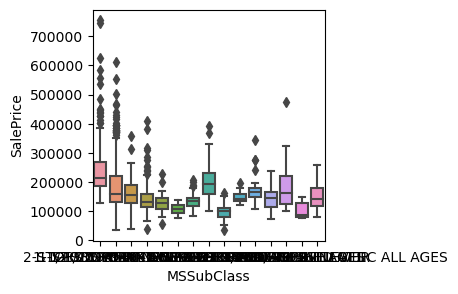

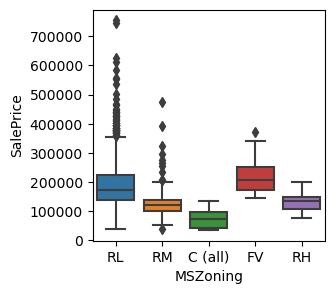

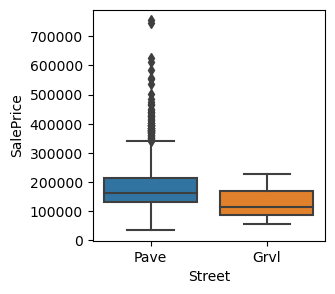

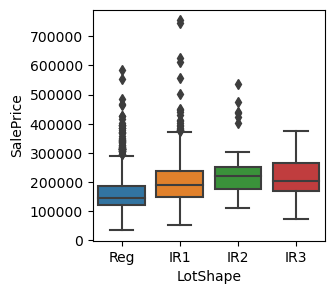

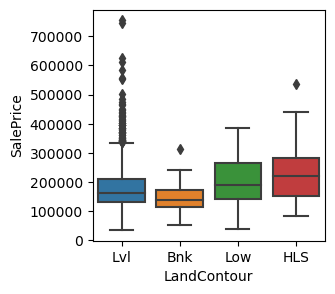

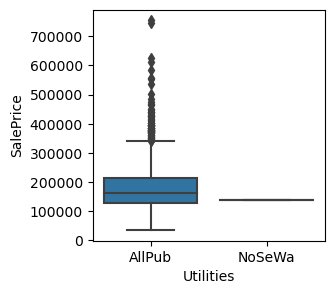

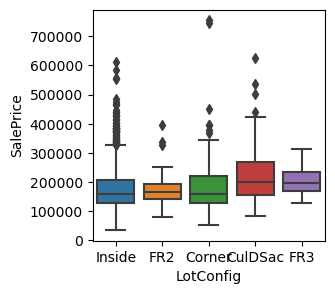

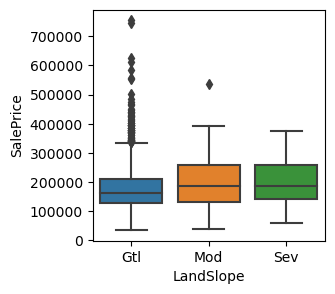

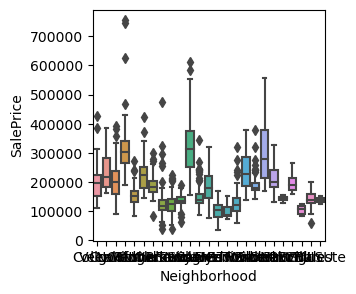

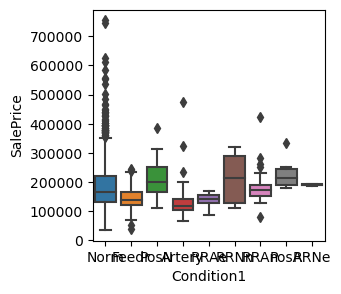

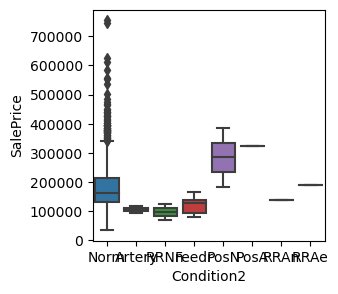

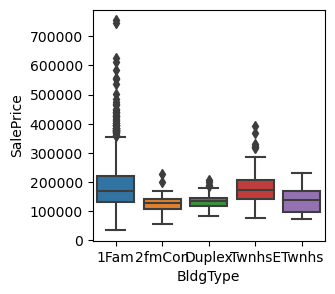

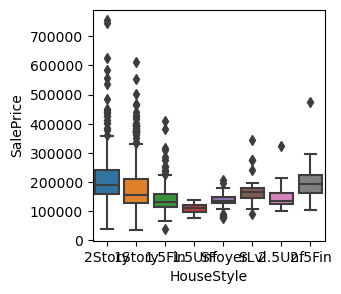

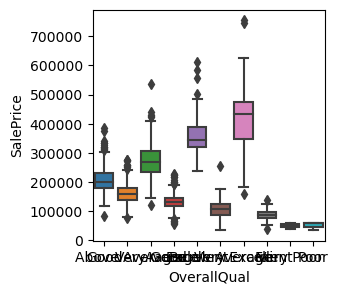

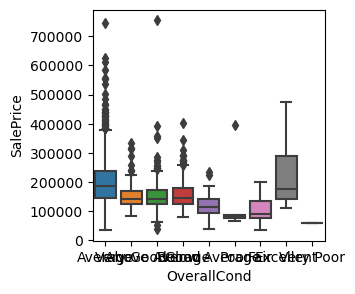

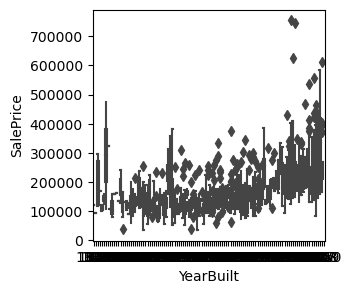

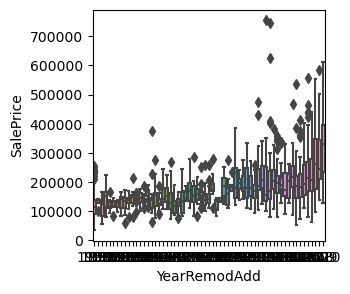

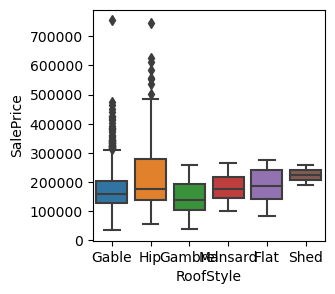

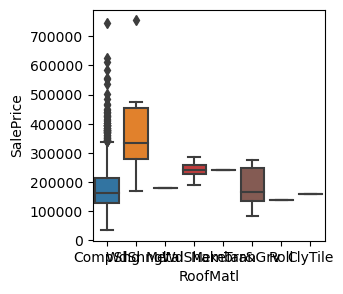

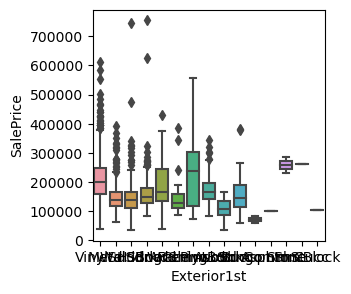

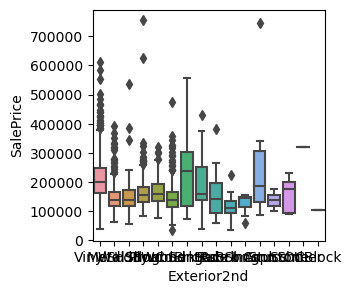

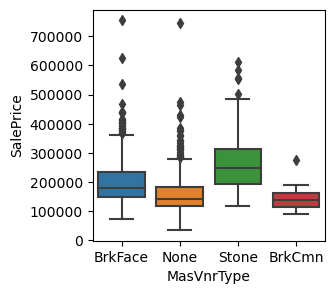

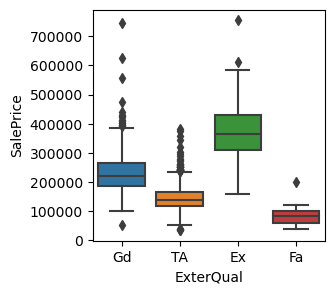

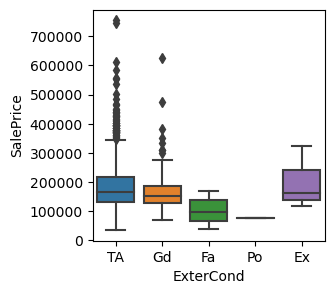

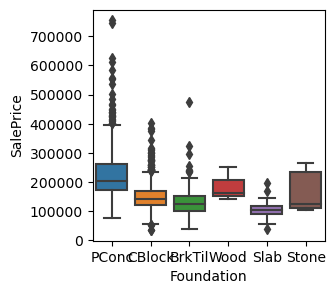

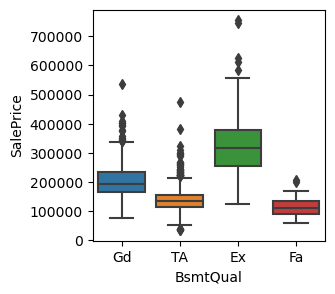

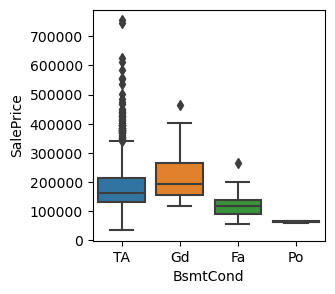

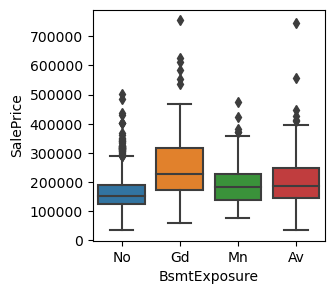

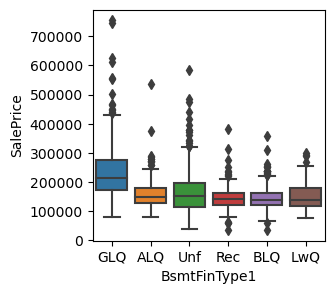

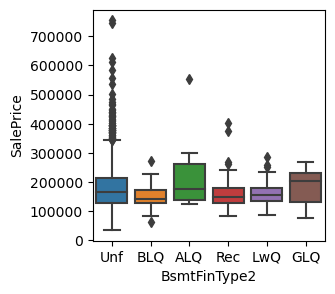

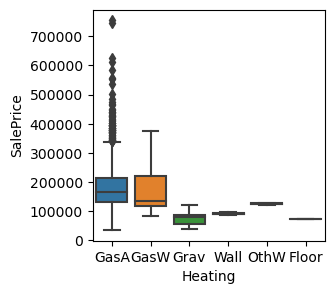

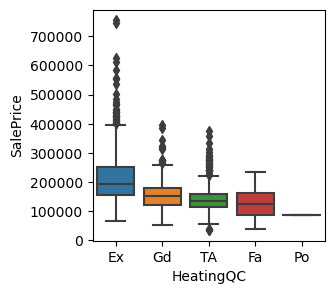

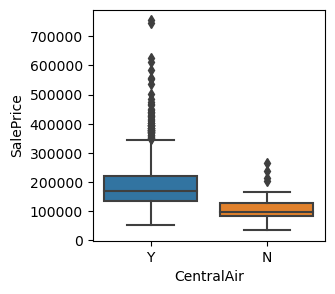

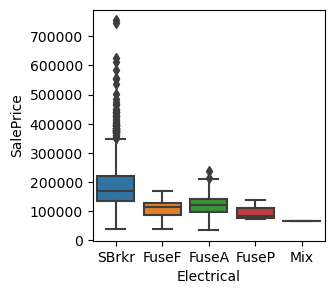

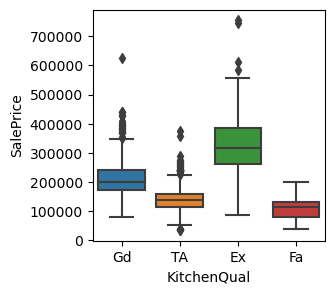

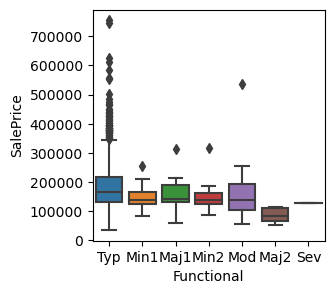

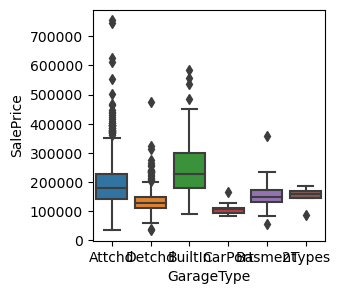

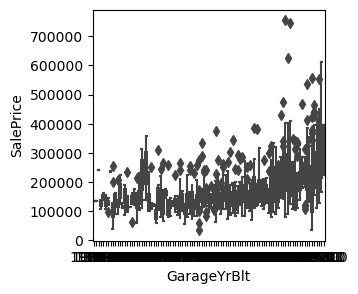

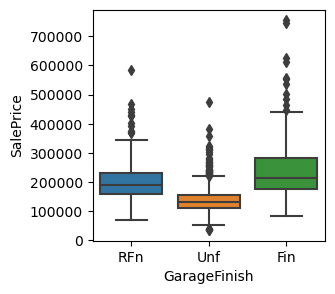

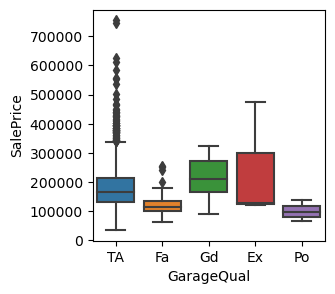

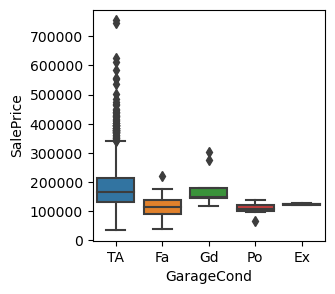

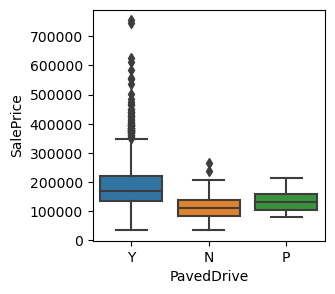

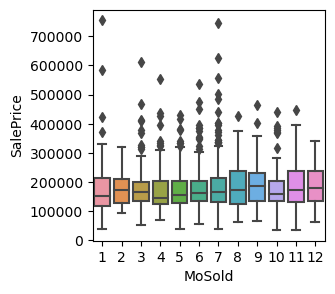

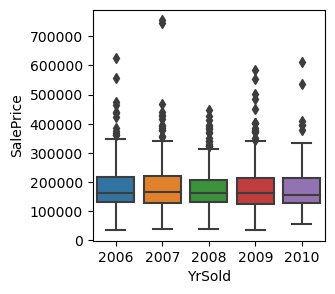

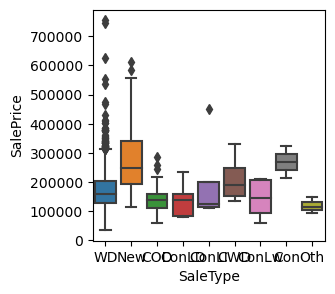

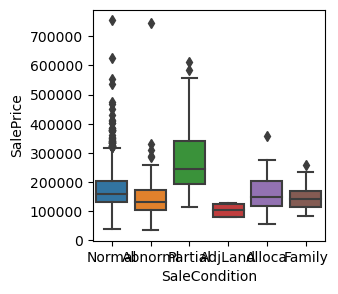

In [24]:
plt.rcParams['figure.figsize'] = [3, 3]
for col in cat_cols:
    sns.boxplot(data=df, x=col, y="SalePrice")
    plt.show()

### Creating dummy variables

In [25]:
# Adding column name to categorical column's values, so they are identifiable after creating dummy variables
for col in cat_cols:
    df[col] =  df[col].apply(lambda x: col +":: "+ str(x))

In [26]:
# Creating dummy variables
for col in cat_cols:
    dummycols = pd.get_dummies(df[col], drop_first=True)
    df = pd.concat([df, dummycols], axis=1)
    df.drop([col], axis=1, inplace=True)

In [27]:
# Converting all column names to string
df.columns = df.columns.astype("str")
df.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'SaleType:: ConLI', 'SaleType:: ConLw', 'SaleType:: New',
       'SaleType:: Oth', 'SaleType:: WD', 'SaleCondition:: AdjLand',
       'SaleCondition:: Alloca', 'SaleCondition:: Family',
       'SaleCondition:: Normal', 'SaleCondition:: Partial'],
      dtype='object', length=538)

### Splitting the Data into Training and Testing Sets

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=10)

### Rescaling the Features (Min-Max Scaling)

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

In [31]:
# Scalling all numerical variables, as all categorical are already 0 or 1
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols] = scaler.fit_transform(df_test[num_cols])

In [32]:
df_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSSubClass:: 1-1/2 STORY FINISHED ALL AGES,MSSubClass:: 1-STORY 1945 OLDER,MSSubClass:: 1-STORY 1946 NEWER,MSSubClass:: 1-STORY PUD - 1946 NEWER,MSSubClass:: 1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass:: 2 FAMILY CONVERSION,MSSubClass:: 2-1/2 STORY ALL AGES,MSSubClass:: 2-STORY 1945 OLDER,MSSubClass:: 2-STORY 1946 NEWER,MSSubClass:: 2-STORY PUD - 1946 NEWER,MSSubClass:: DUPLEX - ALL STYLES AND AGES,MSSubClass:: PUD - MULTILEVEL,MSSubClass:: SPLIT FOYER,MSSubClass:: SPLIT OR MULTI-LEVEL,MSZoning:: FV,MSZoning:: RH,MSZoning:: RL,MSZoning:: RM,Street:: Pave,LotShape:: IR2,LotShape:: IR3,LotShape:: Reg,LandContour:: HLS,LandContour:: Low,LandContour:: Lvl,Utilities:: NoSeWa,LotConfig:: CulDSac,LotConfig:: FR2,LotConfig:: FR3,LotConfig:: Inside,LandSlope:: Mod,LandSlope:: Sev,Neighborhood:: Blueste,Neighborhood:: BrDale,Neighborhood:: BrkSide,Neighborhood:: ClearCr,Neighborhood:: CollgCr,Neighborhood:: Crawfor,Neighborhood:: Edwards,Neighborhood:: Gilbert,Neighborhood:: IDOTRR,Neighborhood:: MeadowV,Neighborhood:: Mitchel,Neighborhood:: NAmes,Neighborhood:: NPkVill,Neighborhood:: NWAmes,Neighborhood:: NoRidge,Neighborhood:: NridgHt,Neighborhood:: OldTown,Neighborhood:: SWISU,Neighborhood:: Sawyer,Neighborhood:: SawyerW,Neighborhood:: Somerst,Neighborhood:: StoneBr,Neighborhood:: Timber,Neighborhood:: Veenker,Condition1:: Feedr,Condition1:: Norm,Condition1:: PosA,Condition1:: PosN,Condition1:: RRAe,Condition1:: RRAn,Condition1:: RRNe,Condition1:: RRNn,Condition2:: Feedr,Condition2:: Norm,Condition2:: PosA,Condition2:: PosN,Condition2:: RRAe,Condition2:: RRAn,Condition2:: RRNn,BldgType:: 2fmCon,BldgType:: Duplex,BldgType:: Twnhs,BldgType:: TwnhsE,HouseStyle:: 1.5Unf,HouseStyle:: 1Story,HouseStyle:: 2.5Fin,HouseStyle:: 2.5Unf,HouseStyle:: 2Story,HouseStyle:: SFoyer,HouseStyle:: SLvl,OverallQual:: Average,OverallQual:: Below Average,OverallQual:: Excellent,OverallQual:: Fair,OverallQual:: Good,OverallQual:: Poor,OverallQual:: Very Excellent,OverallQual:: Very Good,OverallQual:: Very Poor,OverallCond:: Average,OverallCond:: Below Average,OverallCond:: Excellent,OverallCond:: Fair,OverallCond:: Good,OverallCond:: Poor,OverallCond:: Very Good,OverallCond:: Very Poor,YearBuilt:: 1875,YearBuilt:: 1880,YearBuilt:: 1882,YearBuilt:: 1885,YearBuilt:: 1890,YearBuilt:: 1892,YearBuilt:: 1893,YearBuilt:: 1898,YearBuilt:: 1900,YearBuilt:: 1904,YearBuilt:: 1905,YearBuilt:: 1906,YearBuilt:: 1908,YearBuilt:: 1910,YearBuilt:: 1911,YearBuilt:: 1912,YearBuilt:: 1913,YearBuilt:: 1914,YearBuilt:: 1915,YearBuilt:: 1916,YearBuilt:: 1917,YearBuilt:: 1918,YearBuilt:: 1919,YearBuilt:: 1920,YearBuilt:: 1921,YearBuilt:: 1922,YearBuilt:: 1923,YearBuilt:: 1924,YearBuilt:: 1925,YearBuilt:: 1926,YearBuilt:: 1927,YearBuilt:: 1928,YearBuilt:: 1929,YearBuilt:: 1930,YearBuilt:: 1931,YearBuilt:: 1932,YearBuilt:: 1934,YearBuilt:: 1935,YearBuilt:: 1936,YearBuilt:: 1937,YearBuilt:: 1938,YearBuilt:: 1939,YearBuilt:: 1940,YearBuilt:: 1941,YearBuilt:: 1942,YearBuilt:: 1945,YearBuilt:: 1946,YearBuilt:: 1947,YearBuilt:: 1948,YearBuilt:: 1949,YearBuilt:: 1950,YearBuilt:: 1951,YearBuilt:: 1952,YearBuilt:: 1953,YearBuilt:: 1954,YearBuilt:: 1955,YearBuilt:: 1956,YearBuilt:: 1957,YearBuilt:: 1958,YearBuilt:: 1959,YearBuilt:: 1960,YearBuilt:: 1961,YearBuilt:: 1962,YearBuilt:: 1963,YearBuilt:: 1964,YearBuilt:: 1965,YearBuilt:: 1966,YearBuilt:: 1967,YearBuilt:: 1968,YearBuilt:: 1969,YearBuilt:: 1970,YearBuilt:: 1971,YearBuilt:: 1972,YearBuilt:: 1973,YearBuilt:: 1974,YearBuilt:: 1975,YearBuilt:: 1976,YearBuilt:: 1977,YearBuilt:: 1978,YearBuilt:: 1979,YearBuilt:: 1980,YearBuilt:: 1981,YearBuilt:: 1982,YearBuilt:: 1983,YearBuilt:: 1984,YearBuilt:: 1985,YearBuilt:: 1986,YearBuil

In [33]:
df_train.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSSubClass:: 1-1/2 STORY FINISHED ALL AGES,MSSubClass:: 1-STORY 1945 OLDER,MSSubClass:: 1-STORY 1946 NEWER,MSSubClass:: 1-STORY PUD - 1946 NEWER,MSSubClass:: 1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass:: 2 FAMILY CONVERSION,MSSubClass:: 2-1/2 STORY ALL AGES,MSSubClass:: 2-STORY 1945 OLDER,MSSubClass:: 2-STORY 1946 NEWER,MSSubClass:: 2-STORY PUD - 1946 NEWER,MSSubClass:: DUPLEX - ALL STYLES AND AGES,MSSubClass:: PUD - MULTILEVEL,MSSubClass:: SPLIT FOYER,MSSubClass:: SPLIT OR MULTI-LEVEL,MSZoning:: FV,MSZoning:: RH,MSZoning:: RL,MSZoning:: RM,Street:: Pave,LotShape:: IR2,LotShape:: IR3,LotShape:: Reg,LandContour:: HLS,LandContour:: Low,LandContour:: Lvl,Utilities:: NoSeWa,LotConfig:: CulDSac,LotConfig:: FR2,LotConfig:: FR3,LotConfig:: Inside,LandSlope:: Mod,LandSlope:: Sev,Neighborhood:: Blueste,Neighborhood:: BrDale,Neighborhood:: BrkSide,Neighborhood:: ClearCr,Neighborhood:: CollgCr,Neighborhood:: Crawfor,Neighborhood:: Edwards,Neighborhood:: Gilbert,Neighborhood:: IDOTRR,Neighborhood:: MeadowV,Neighborhood:: Mitchel,Neighborhood:: NAmes,Neighborhood:: NPkVill,Neighborhood:: NWAmes,Neighborhood:: NoRidge,Neighborhood:: NridgHt,Neighborhood:: OldTown,Neighborhood:: SWISU,Neighborhood:: Sawyer,Neighborhood:: SawyerW,Neighborhood:: Somerst,Neighborhood:: StoneBr,Neighborhood:: Timber,Neighborhood:: Veenker,Condition1:: Feedr,Condition1:: Norm,Condition1:: PosA,Condition1:: PosN,Condition1:: RRAe,Condition1:: RRAn,Condition1:: RRNe,Condition1:: RRNn,Condition2:: Feedr,Condition2:: Norm,Condition2:: PosA,Condition2:: PosN,Condition2:: RRAe,Condition2:: RRAn,Condition2:: RRNn,BldgType:: 2fmCon,BldgType:: Duplex,BldgType:: Twnhs,BldgType:: TwnhsE,HouseStyle:: 1.5Unf,HouseStyle:: 1Story,HouseStyle:: 2.5Fin,HouseStyle:: 2.5Unf,HouseStyle:: 2Story,HouseStyle:: SFoyer,HouseStyle:: SLvl,OverallQual:: Average,OverallQual:: Below Average,OverallQual:: Excellent,OverallQual:: Fair,OverallQual:: Good,OverallQual:: Poor,OverallQual:: Very Excellent,OverallQual:: Very Good,OverallQual:: Very Poor,OverallCond:: Average,OverallCond:: Below Average,OverallCond:: Excellent,OverallCond:: Fair,OverallCond:: Good,OverallCond:: Poor,OverallCond:: Very Good,OverallCond:: Very Poor,YearBuilt:: 1875,YearBuilt:: 1880,YearBuilt:: 1882,YearBuilt:: 1885,YearBuilt:: 1890,YearBuilt:: 1892,YearBuilt:: 1893,YearBuilt:: 1898,YearBuilt:: 1900,YearBuilt:: 1904,YearBuilt:: 1905,YearBuilt:: 1906,YearBuilt:: 1908,YearBuilt:: 1910,YearBuilt:: 1911,YearBuilt:: 1912,YearBuilt:: 1913,YearBuilt:: 1914,YearBuilt:: 1915,YearBuilt:: 1916,YearBuilt:: 1917,YearBuilt:: 1918,YearBuilt:: 1919,YearBuilt:: 1920,YearBuilt:: 1921,YearBuilt:: 1922,YearBuilt:: 1923,YearBuilt:: 1924,YearBuilt:: 1925,YearBuilt:: 1926,YearBuilt:: 1927,YearBuilt:: 1928,YearBuilt:: 1929,YearBuilt:: 1930,YearBuilt:: 1931,YearBuilt:: 1932,YearBuilt:: 1934,YearBuilt:: 1935,YearBuilt:: 1936,YearBuilt:: 1937,YearBuilt:: 1938,YearBuilt:: 1939,YearBuilt:: 1940,YearBuilt:: 1941,YearBuilt:: 1942,YearBuilt:: 1945,YearBuilt:: 1946,YearBuilt:: 1947,YearBuilt:: 1948,YearBuilt:: 1949,YearBuilt:: 1950,YearBuilt:: 1951,YearBuilt:: 1952,YearBuilt:: 1953,YearBuilt:: 1954,YearBuilt:: 1955,YearBuilt:: 1956,YearBuilt:: 1957,YearBuilt:: 1958,YearBuilt:: 1959,YearBuilt:: 1960,YearBuilt:: 1961,YearBuilt:: 1962,YearBuilt:: 1963,YearBuilt:: 1964,YearBuilt:: 1965,YearBuilt:: 1966,YearBuilt:: 1967,YearBuilt:: 1968,YearBuilt:: 1969,YearBuilt:: 1970,YearBuilt:: 1971,YearBuilt:: 1972,YearBuilt:: 1973,YearBuilt:: 1974,YearBuilt:: 1975,YearBuilt:: 1976,YearBuilt:: 1977,YearBuilt:: 1978,YearBuilt:: 1979,YearBuilt:: 1980,YearBuilt:: 1981,YearBuilt:: 1982,YearBuilt:: 1983,YearBuilt:: 1984,YearBuilt:: 1985,YearBuilt:: 1986,YearBuil

#### Checking Correlation between "SalePrice" and all features

In [34]:
df_train.corr()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSSubClass:: 1-1/2 STORY FINISHED ALL AGES,MSSubClass:: 1-STORY 1945 OLDER,MSSubClass:: 1-STORY 1946 NEWER,MSSubClass:: 1-STORY PUD - 1946 NEWER,MSSubClass:: 1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass:: 2 FAMILY CONVERSION,MSSubClass:: 2-1/2 STORY ALL AGES,MSSubClass:: 2-STORY 1945 OLDER,MSSubClass:: 2-STORY 1946 NEWER,MSSubClass:: 2-STORY PUD - 1946 NEWER,MSSubClass:: DUPLEX - ALL STYLES AND AGES,MSSubClass:: PUD - MULTILEVEL,MSSubClass:: SPLIT FOYER,MSSubClass:: SPLIT OR MULTI-LEVEL,MSZoning:: FV,MSZoning:: RH,MSZoning:: RL,MSZoning:: RM,Street:: Pave,LotShape:: IR2,LotShape:: IR3,LotShape:: Reg,LandContour:: HLS,LandContour:: Low,LandContour:: Lvl,Utilities:: NoSeWa,LotConfig:: CulDSac,LotConfig:: FR2,LotConfig:: FR3,LotConfig:: Inside,LandSlope:: Mod,LandSlope:: Sev,Neighborhood:: Blueste,Neighborhood:: BrDale,Neighborhood:: BrkSide,Neighborhood:: ClearCr,Neighborhood:: CollgCr,Neighborhood:: Crawfor,Neighborhood:: Edwards,Neighborhood:: Gilbert,Neighborhood:: IDOTRR,Neighborhood:: MeadowV,Neighborhood:: Mitchel,Neighborhood:: NAmes,Neighborhood:: NPkVill,Neighborhood:: NWAmes,Neighborhood:: NoRidge,Neighborhood:: NridgHt,Neighborhood:: OldTown,Neighborhood:: SWISU,Neighborhood:: Sawyer,Neighborhood:: SawyerW,Neighborhood:: Somerst,Neighborhood:: StoneBr,Neighborhood:: Timber,Neighborhood:: Veenker,Condition1:: Feedr,Condition1:: Norm,Condition1:: PosA,Condition1:: PosN,Condition1:: RRAe,Condition1:: RRAn,Condition1:: RRNe,Condition1:: RRNn,Condition2:: Feedr,Condition2:: Norm,Condition2:: PosA,Condition2:: PosN,Condition2:: RRAe,Condition2:: RRAn,Condition2:: RRNn,BldgType:: 2fmCon,BldgType:: Duplex,BldgType:: Twnhs,BldgType:: TwnhsE,HouseStyle:: 1.5Unf,HouseStyle:: 1Story,HouseStyle:: 2.5Fin,HouseStyle:: 2.5Unf,HouseStyle:: 2Story,HouseStyle:: SFoyer,HouseStyle:: SLvl,OverallQual:: Average,OverallQual:: Below Average,OverallQual:: Excellent,OverallQual:: Fair,OverallQual:: Good,OverallQual:: Poor,OverallQual:: Very Excellent,OverallQual:: Very Good,OverallQual:: Very Poor,OverallCond:: Average,OverallCond:: Below Average,OverallCond:: Excellent,OverallCond:: Fair,OverallCond:: Good,OverallCond:: Poor,OverallCond:: Very Good,OverallCond:: Very Poor,YearBuilt:: 1875,YearBuilt:: 1880,YearBuilt:: 1882,YearBuilt:: 1885,YearBuilt:: 1890,YearBuilt:: 1892,YearBuilt:: 1893,YearBuilt:: 1898,YearBuilt:: 1900,YearBuilt:: 1904,YearBuilt:: 1905,YearBuilt:: 1906,YearBuilt:: 1908,YearBuilt:: 1910,YearBuilt:: 1911,YearBuilt:: 1912,YearBuilt:: 1913,YearBuilt:: 1914,YearBuilt:: 1915,YearBuilt:: 1916,YearBuilt:: 1917,YearBuilt:: 1918,YearBuilt:: 1919,YearBuilt:: 1920,YearBuilt:: 1921,YearBuilt:: 1922,YearBuilt:: 1923,YearBuilt:: 1924,YearBuilt:: 1925,YearBuilt:: 1926,YearBuilt:: 1927,YearBuilt:: 1928,YearBuilt:: 1929,YearBuilt:: 1930,YearBuilt:: 1931,YearBuilt:: 1932,YearBuilt:: 1934,YearBuilt:: 1935,YearBuilt:: 1936,YearBuilt:: 1937,YearBuilt:: 1938,YearBuilt:: 1939,YearBuilt:: 1940,YearBuilt:: 1941,YearBuilt:: 1942,YearBuilt:: 1945,YearBuilt:: 1946,YearBuilt:: 1947,YearBuilt:: 1948,YearBuilt:: 1949,YearBuilt:: 1950,YearBuilt:: 1951,YearBuilt:: 1952,YearBuilt:: 1953,YearBuilt:: 1954,YearBuilt:: 1955,YearBuilt:: 1956,YearBuilt:: 1957,YearBuilt:: 1958,YearBuilt:: 1959,YearBuilt:: 1960,YearBuilt:: 1961,YearBuilt:: 1962,YearBuilt:: 1963,YearBuilt:: 1964,YearBuilt:: 1965,YearBuilt:: 1966,YearBuilt:: 1967,YearBuilt:: 1968,YearBuilt:: 1969,YearBuilt:: 1970,YearBuilt:: 1971,YearBuilt:: 1972,YearBuilt:: 1973,YearBuilt:: 1974,YearBuilt:: 1975,YearBuilt:: 1976,YearBuilt:: 1977,YearBuilt:: 1978,YearBuilt:: 1979,YearBuilt:: 1980,YearBuilt:: 1981,YearBuilt:: 1982,YearBuilt:: 1983,YearBuilt:: 1984,YearBuilt:: 1985,YearBuilt:: 1986,YearBuil

In [35]:
# Dividing into X and Y sets for the model building 
x_train = df_train.drop("SalePrice", axis=1)
y_train = np.array(df_train['SalePrice']).reshape(-1,1)
x_test = df_test.drop("SalePrice", axis=1)
y_test = np.array(df_test['SalePrice']).reshape(-1,1)

### Performing Linear regression

In [36]:
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [37]:
print(lm.intercept_)
print(lm.coef_)

[-8.9239179e+09]
[[ 3.28346427e-02  2.04984639e-01  2.35455964e-02 -1.41088423e+11
  -3.68469765e+10 -5.83952083e+10  1.52737467e+11  1.84182075e+11
   8.80407372e+10  2.43870710e+10 -2.14751183e+11  8.25119019e-03
   2.78759003e-03  2.21366882e-02 -2.30407715e-03 -2.33688354e-02
   1.06163025e-02  1.83677673e-02  7.11441040e-03  3.13415527e-02
   3.43055725e-02  2.09026337e-02 -4.30297852e-03  3.04026604e-02
   3.91373634e-02  3.56626511e-02  1.47102356e-01  2.03466415e-03
   1.55067444e-03  2.45399475e-02  2.51541138e-02  4.28009033e-03
   2.99106836e-02 -1.18510184e+09 -2.41923332e-02  2.25524902e-02
   1.78222656e-02 -2.48718262e-03  4.02829187e+09 -2.14390755e-02
  -2.55966187e-02 -5.50127029e-03  6.12697601e-02  4.27687168e-02
   4.18663025e-02  3.37600708e-02  6.89821243e-02  4.40979004e-03
  -3.18908691e-03  1.38854980e-03  3.28769684e-02  2.18677521e-02
   2.85282135e-02 -9.80226994e-02  1.27382278e-02 -1.56631470e-02
  -1.54006481e-02 -2.36511230e-03  2.13737488e-02 -7.065200

In [38]:
# Evaluating R2 score, RSS and RMSE
y_pred_train = lm.predict(x_train)
y_pred_test = lm.predict(x_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 train: "+str(r2_train_lr))
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 test: "+str(r2_test_lr))
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS train: "+str(rss1_lr))
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS test: "+str(rss2_lr))
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE train: "+str(mse_train_lr))
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE test: "+str(mse_test_lr))
metric.append(mse_test_lr**0.5)

R2 train: 0.9550529519176578
R2 test: -1.773538893582962e+22
RSS train: 0.5827012693882316
RSS test: 1.3680743628027706e+23
MSE train: 0.000570716228587886
MSE test: 3.1234574493213943e+20


- With linear regression there is a big defference between R2 of train and test sets.
- This indicates overfittting. 
- Lets try Ridge and Lasso Regression

### Ridge Regression (with cross validation)

In [39]:
lambdas = {'alpha': [0, 0.001, 0.01, 0.1, 1, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20, 50, 100, 1000]}
ridge = Ridge()
ridge_model = GridSearchCV(estimator = ridge, 
                        param_grid = lambdas, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 1, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10, 20, 50, 100, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [40]:
print(ridge_model.best_params_)

{'alpha': 10}


In [41]:
#Fitting Ridge model for alpha = 10 and printing coefficients
ridge_model = Ridge(alpha=10)
ridge_model.fit(x_train, y_train)
print(ridge_model.coef_)

[[-2.20753631e-03  1.91699368e-02  2.59388115e-02  8.33203998e-03
   3.91819223e-03  1.46482938e-02  1.42422035e-02  3.42952729e-02
   5.38293107e-02  4.04653747e-03  5.19411803e-02  1.64963662e-02
   9.68280518e-04  4.64883005e-02  1.21702130e-02  8.53552911e-03
  -1.12925332e-02  4.29478387e-02  2.54485434e-02  4.25213673e-02
   2.40490387e-02  2.30141718e-02  5.25113000e-03  6.26061500e-03
   9.39886103e-03  1.49584121e-02  9.62173441e-03 -1.71963645e-03
   3.76927916e-03 -4.27958346e-03  1.11600253e-02 -7.75566168e-03
   4.47436455e-03 -6.69272345e-03  8.25426229e-03  3.05248892e-03
   4.68081005e-03 -1.29256206e-02  9.94005958e-05 -5.11644153e-03
  -3.82435468e-03  6.97269755e-04  1.20357268e-02  4.33944547e-03
   1.04081505e-02 -2.53247780e-03  7.39073301e-03  1.13622469e-02
  -1.33125094e-02 -1.26919851e-03  1.49294169e-02  1.14848079e-02
   1.65427257e-02 -5.21860568e-03  1.62096286e-02 -1.26733115e-02
  -3.03880013e-03 -4.57125926e-03  1.75979240e-02  1.21919747e-03
  -2.73273

In [42]:
# Evaluating R2 score, RSS and RMSE
y_pred_train = ridge_model.predict(x_train)
y_pred_test = ridge_model.predict(x_test)

metric2 = []
r2_train = r2_score(y_train, y_pred_train)
print("R2 train: "+str(r2_train))
metric2.append(r2_train)

r2_test = r2_score(y_test, y_pred_test)
print("R2 test: "+str(r2_test))
metric2.append(r2_test)

rss1 = np.sum(np.square(y_train - y_pred_train))
print("RSS train: "+str(rss1))
metric2.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print("RSS test: "+str(rss2))
metric2.append(rss2)

mse_train = mean_squared_error(y_train, y_pred_train)
print("MSE train: "+str(mse_train))
metric2.append(mse_train**0.5)

mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE test: "+str(mse_test))
metric2.append(mse_test**0.5)

R2 train: 0.8957686821138113
R2 test: 0.8261472503464415
RSS train: 1.3512727494589583
RSS test: 1.3410672332271343
MSE train: 0.0013234796762575498
MSE test: 0.00306179733613501


- Difference between R2 of train and test set is very less now, and R2 test is now in acceptable range

#### Residual Analysis of the training data

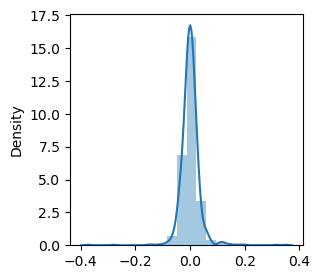

In [43]:
# checking if error terms are normally distributed.
sns.distplot(y_train-ridge_model.predict(x_train), bins=20)
plt.show()

- Yes, error terms are normally distributed around zero.

### Performing Lasso regression (with cross validation)

In [44]:
lambdas = {'alpha': [0, 0.00001,0.0001,0.001, 0.01, 0.1, 1, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10]}
lasso = Lasso()
lasso_model = GridSearchCV(estimator = lasso, 
                        param_grid = lambdas, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            
lasso_model.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [45]:
# Finding best lambda
print(lasso_model.best_params_)

{'alpha': 0.0001}


In [46]:
#Fitting Lasso model for alpha = 0.0001 and printing coefficients
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(x_train, y_train)
print(lasso_model.coef_)

[-0.00000000e+00  5.71413759e-02  1.04676439e-02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.26354038e-02 -0.00000000e+00  2.44694584e-01  1.52148811e-02
  0.00000000e+00  3.64612601e-02  3.24481746e-03 -0.00000000e+00
 -2.01285298e-02  1.90853812e-02  1.75777062e-02  6.08801121e-02
  0.00000000e+00  1.87495030e-02  0.00000000e+00  0.00000000e+00
  7.94817761e-03  1.69469949e-02  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.13029314e-02 -0.00000000e+00
  0.00000000e+00 -5.88723509e-03 -0.00000000e+00 -0.00000000e+00
  2.54036456e-04 -1.21315607e-03  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  4.38048001e-03  0.00000000e+00
  3.88963939e-03 -0.00000000e+00  2.31133107e-03  1.20237004e-02
 -2.23953921e-02 -0.00000000e+00  1.63073051e-02  1.22144848e-02
  2.15960045e-02 -0.00000000e+00  1.73436291e-02 -1.05846547e-02
 -0.00000000e+00 -1.38098241e-03  1.76456305e-02  0.00000000e+00
 -0.00000000e+00  0.00000

In [47]:
# Evaluating R2 score, RSS and RMSE
y_pred_train = lasso_model.predict(x_train)
y_pred_test = lasso_model.predict(x_test)

metric3 = []
r2_train = r2_score(y_train, y_pred_train)
print("R2 train: "+str(r2_train))
metric3.append(r2_train)

r2_test = r2_score(y_test, y_pred_test)
print("R2 test: "+str(r2_test))
metric3.append(r2_test)

rss1 = np.sum(np.square(y_train - y_pred_train))
print("RSS train: "+str(rss1))
metric3.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print("RSS test: "+str(rss2))
metric3.append(rss2)

mse_train = mean_squared_error(y_train, y_pred_train)
print("MSE train: "+str(mse_train))
metric3.append(mse_train**0.5)

mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE test: "+str(mse_test))
metric3.append(mse_test**0.5)

R2 train: 0.9073784786468737
R2 test: 0.8703536012033858
RSS train: 24729.057629129882
RSS test: 5899.291310214292
MSE train: 0.0011760640043788626
MSE test: 0.0022832598234194547


- Difference between R2 of train and test set is very less for Lasso regression as well, and R2 test is also in acceptable range

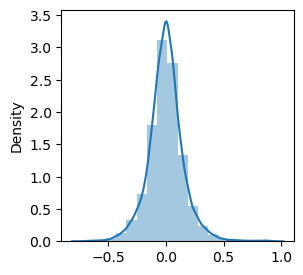

In [48]:
# checking if error terms are normally distributed.
sns.distplot(y_train-lasso_model.predict(x_train), bins=20)
plt.show()

- Yes, error terms are normally distributed around zero.

In [49]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }
lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')
final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)
final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.550530e-01,0.895769,0.907378
1,R2 Score (Test),-1.773539e+22,0.826147,0.870354
2,RSS (Train),5.827013e-01,1.351273,24729.057629
3,RSS (Test),1.368074e+23,1.341067,5899.291310
4,MSE (Train),2.388967e-02,0.036380,0.034294
5,MSE (Test),1.767331e+10,0.055334,0.047783


- Difference between R2 of train and test set is less in Lasso Regression than in Ridge Regression
- Difference in MSE is also less with Lasso Regression

### We shall choose Lasso Regression

In [50]:
coefs = pd.DataFrame(index=x_train.columns)
coefs.rows = x_train.columns
coefs['Linear'] = lm.coef_[0]
coefs['Ridge'] = ridge_model.coef_[0]
coefs['Lasso'] = lasso_model.coef_
pd.set_option('display.max_rows', None)

In [51]:
coefs[coefs.Lasso>0].sort_values("Lasso", ascending=False)

,Linear,Ridge,Lasso
GrLivArea,-2.147512e+11,0.051941,0.244695
RoofMatl:: WdShngl,1.088215e+00,0.046418,0.113420
OverallQual:: Very Excellent,1.360474e-01,0.053530,0.113226
OverallQual:: Excellent,7.468605e-02,0.060568,0.097398
Neighborhood:: NoRidge,3.315449e-02,0.053449,0.068577
2ndFlrSF,8.804074e+10,0.053829,0.062635
GarageCars,3.134155e-02,0.042521,0.060880
LotArea,2.049846e-01,0.019170,0.057141
Neighborhood:: StoneBr,2.667141e-02,0.033936,0.053769
Neighborhood:: NridgHt,1.842022e-02,0.031235,0.044778


#### According to Lasso Regression following are the most significant in predicting price of house
- GrLivArea
- RoofMatl:: WdShngl
- OverallQual:: Very Excellent
- OverallQual:: Excellent
- Neighborhood:: NoRidge

## Assignment Part-II

### Answer for Question 1

- Optimal value of alpha for ridge regression = 10
- Optimal value of alpha for lasso regression = 0.0001

In [52]:
#Fitting Ridge model for double the optimum alpha i.e. alpha = 20
ridge_model = Ridge(alpha=20)
ridge_model.fit(x_train, y_train)

# Evaluating R2 score, RSS and RMSE
y_pred_train = ridge_model.predict(x_train)
y_pred_test = ridge_model.predict(x_test)

metric2 = []
r2_train = r2_score(y_train, y_pred_train)
print("R2 train: "+str(r2_train))
metric2.append(r2_train)

r2_test = r2_score(y_test, y_pred_test)
print("R2 test: "+str(r2_test))
metric2.append(r2_test)

rss1 = np.sum(np.square(y_train - y_pred_train))
print("RSS train: "+str(rss1))
metric2.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print("RSS test: "+str(rss2))
metric2.append(rss2)

mse_train = mean_squared_error(y_train, y_pred_train)
print("MSE train: "+str(mse_train))
metric2.append(mse_train**0.5)

mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE test: "+str(mse_test))
metric2.append(mse_test**0.5)

R2 train: 0.8778130377608031
R2 test: 0.8076205599745094
RSS train: 1.5840528140810868
RSS test: 1.483978619141094
MSE train: 0.0015514719040950898
MSE test: 0.0033880790391349175


In [53]:
#Fitting Lasso model for double the optimum alpha i.e. alpha = 0.0002
lasso_model = Lasso(alpha=0.0002)
lasso_model.fit(x_train, y_train)

# Evaluating R2 score, RSS and RMSE
y_pred_train = lasso_model.predict(x_train)
y_pred_test = lasso_model.predict(x_test)

metric3 = []
r2_train = r2_score(y_train, y_pred_train)
print("R2 train: "+str(r2_train))
metric3.append(r2_train)

r2_test = r2_score(y_test, y_pred_test)
print("R2 test: "+str(r2_test))
metric3.append(r2_test)

rss1 = np.sum(np.square(y_train - y_pred_train))
print("RSS train: "+str(rss1))
metric3.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print("RSS test: "+str(rss2))
metric3.append(rss2)

mse_train = mean_squared_error(y_train, y_pred_train)
print("MSE train: "+str(mse_train))
metric3.append(mse_train**0.5)

mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE test: "+str(mse_test))
metric3.append(mse_test**0.5)

R2 train: 0.8932691601353828
R2 test: 0.8632406667447176
RSS train: 24289.41284897992
RSS test: 5788.78833080432
MSE train: 0.0013552174169471694
MSE test: 0.002408528844594281


In [54]:
coefs = pd.DataFrame(index=x_train.columns)
coefs.rows = x_train.columns
coefs['Linear'] = lm.coef_[0]
coefs['Ridge'] = ridge_model.coef_[0]
coefs['Lasso'] = lasso_model.coef_
pd.set_option('display.max_rows', None)

In [55]:
coefs[coefs.Lasso>0].sort_values("Lasso", ascending=False)

,Linear,Ridge,Lasso
GrLivArea,-2.147512e+11,0.041771,0.234792
OverallQual:: Very Excellent,1.360474e-01,0.040044,0.103379
OverallQual:: Excellent,7.468605e-02,0.049847,0.101395
RoofMatl:: WdShngl,1.088215e+00,0.030468,0.080252
Neighborhood:: NoRidge,3.315449e-02,0.043304,0.068439
GarageCars,3.134155e-02,0.036210,0.065144
2ndFlrSF,8.804074e+10,0.041710,0.052084
Neighborhood:: StoneBr,2.667141e-02,0.025810,0.051253
Neighborhood:: NridgHt,1.842022e-02,0.028225,0.041748
FullBath,2.213669e-02,0.039798,0.039728


#### After doubling the alpha the top 5 predictors from Lasso Regression are still the same but their coefficient values have changed. RoofMatl is less significant now than OverallQual
- GrLivArea
- OverallQual:: Very Excellent
- OverallQual:: Excellent
- RoofMatl:: WdShngl
- Neighborhood:: NoRidge

### Answer for Question 2

- I will apply Lasso Regression because it gives less difference when we compare R2, RSS and MSE scores of train and test sets. This means Lasso is more consistent in this case.
- Also, we had lot of variables here. Lasso helps in reducing the number of variables, as it also does feature selection.

### Answer for Question 3

- If we remove the top 5 most important predictor variables in the lasso model

In [56]:
x_train.drop(["GrLivArea","RoofMatl:: WdShngl", "OverallQual:: Very Excellent", 
              "OverallQual:: Excellent","Neighborhood:: NoRidge"], axis=1, inplace=True)
x_test.drop(["GrLivArea","RoofMatl:: WdShngl", "OverallQual:: Very Excellent", 
              "OverallQual:: Excellent","Neighborhood:: NoRidge"], axis=1, inplace=True)

In [57]:
lambdas = {'alpha': [0, 0.00001,0.0001,0.001, 0.01, 0.1, 1, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10]}
lasso = Lasso()
lasso_model = GridSearchCV(estimator = lasso, 
                        param_grid = lambdas, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            
lasso_model.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [58]:
# Finding best lambda
print(lasso_model.best_params_)

{'alpha': 0.0001}


In [59]:
#Fitting Lasso model for alpha = 0.0001 and printing coefficients
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(x_train, y_train)
print(lasso_model.coef_)

[-0.00000000e+00  7.08446383e-02  4.45480303e-02 -0.00000000e+00
 -0.00000000e+00  7.77933378e-03  0.00000000e+00  2.58288917e-01
  2.07604449e-01  0.00000000e+00  1.86461649e-02  0.00000000e+00
  3.68789293e-02  1.30669890e-03 -3.54452801e-03 -2.85476627e-02
  1.57012601e-02  1.40759963e-02  8.12176113e-02  0.00000000e+00
  2.94791813e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.11814744e-02  0.00000000e+00 -0.00000000e+00 -4.92543204e-03
  0.00000000e+00  1.12901556e-02 -0.00000000e+00  0.00000000e+00
 -1.22001525e-02  0.00000000e+00 -0.00000000e+00  1.54437127e-03
 -5.15684621e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.66367423e-04  1.05113314e-02  0.00000000e+00  9.31935115e-03
 -0.00000000e+00  1.31676084e-02  4.41163187e-03 -3.44875518e-02
 -2.02136656e-04  2.09057745e-02  1.92848577e-02  2.45390254e-02
 -0.00000000e+00  1.79406021e-02 -7.31124986e-03 -0.00000000e+00
 -1.52988155e-03  8.31327624e-03 -3.79242393e-03 -0.00000000e+00
  0.00000000e+00 -0.00000

In [60]:
# Evaluating R2 score, RSS and RMSE
y_pred_train = lasso_model.predict(x_train)
y_pred_test = lasso_model.predict(x_test)

metric3 = []
r2_train = r2_score(y_train, y_pred_train)
print("R2 train: "+str(r2_train))
metric3.append(r2_train)

r2_test = r2_score(y_test, y_pred_test)
print("R2 test: "+str(r2_test))
metric3.append(r2_test)

rss1 = np.sum(np.square(y_train - y_pred_train))
print("RSS train: "+str(rss1))
metric3.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print("RSS test: "+str(rss2))
metric3.append(rss2)

mse_train = mean_squared_error(y_train, y_pred_train)
print("MSE train: "+str(mse_train))
metric3.append(mse_train**0.5)

mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE test: "+str(mse_test))
metric3.append(mse_test**0.5)

R2 train: 0.8887386572202285
R2 test: 0.8717285538876267
RSS train: 24448.733665666496
RSS test: 5966.183464856044
MSE train: 0.001412743587133172
MSE test: 0.0022590449261899914


In [61]:
coefs = pd.DataFrame(index=x_train.columns)
coefs.rows = x_train.columns
coefs['Lasso'] = lasso_model.coef_

In [62]:
coefs[coefs.Lasso>0].sort_values("Lasso", ascending=False)

,Lasso
1stFlrSF,0.258289
2ndFlrSF,0.207604
GarageCars,0.081218
LotArea,0.070845
Exterior2nd:: ImStucc,0.049488
Neighborhood:: StoneBr,0.049432
MasVnrArea,0.044548
Neighborhood:: NridgHt,0.038512
FullBath,0.036879
WoodDeckSF,0.029479


#### Top five most important predictor variables now are:
- 1stFlrSF
- 2ndFlrSF
- GarageCars
- LotArea
- Exterior2nd:: ImStucc

### Answer for Question 4

- To make sure that our model is robust and generalisable, we compare the difference between R2, RSS and MSE scores of train and test sets. 
- If the difference is not very large it means our model is able to generalise and predict on unseen data.
- The accuracy is represented by R2. If R2 from both train and test set is high enough, and the difference is not too much, we can say our model is accurate enough.
- If the R2 score is not too high, it indicates that our model is not overfitted on the train data.